__Project submitted by:__<br>
__Pranay Raturi (24920)__<br>
__Divij Jasuja (24954)__

## Does twitter affect stock prices

#### Index

1. [Problem Statement](#problem-statement)
2. [Libraries used](#libraries-used)
3. [Collection of data](#collection-of-data)<br>
    3.1. [Collecting stock data]()<br>
    3.2. [Collecting tweets]()
4. [Data cleaning](#data-cleaning)
5. [Sentiment Analysis](#sentiment-analysis)
6. [Visualizing the correlation between twitter sentiment and stock performance](#vizualization)
7. [Applying LSTM](#applying-lstm) 
8. [Conclusions](#conclusions)

#### Problem Statement

The project aims to utilize sentiment analysis techniques on tweets related to NVIDIA Corporation (NASDAQ: NVDA) to explore and establish correlations between the sentiments expressed in these tweets and the subsequent stock performance of NVIDIA. The goal is to leverage these findings to develop a predictive model that can assist in forecasting stock movements based on sentiment trends in social media.<br><br>
The objectives of the project are as follows:
- Gather historical stock performance data for NVIDIA during Q1 2024.
- Collect a comprehensive dataset of tweets mentioning NVIDIA or related keywords over the same period.
- Implement sentiment analysis algorithms to quantify the sentiments expressed in these tweets as positive negative, or neutral.
- Conduct statistical analysis to identify correlations between sentiment trends in tweets and subsequent stock price movements.
- Use the findings to develop a predictive model.

#### Libraries used

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# For general data handling 
import pandas as pd
import numpy as np
import os
from datetime import date

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# For fetching stock data and tweets
import yfinance as yf
from twscrape import API, gather

# For processing textual data
import demoji
import re
import string
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag

# For sentiment analysis
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from tqdm import tqdm

# For LSTM 
import torch
from torch import nn
from torch import optim

The reasoning behind the selection of certain libraries will be explained later in the project, when said libraries are utilized

#### Collection of data

##### Collecting stock data

In [3]:
# NVDA is the stock ticker of Nvidia on the NASDAQ
ticker = "NVDA"
start_date = "2024-01-01"
end_date = "2024-03-31"
# download the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date) 
# convert the downloaded data into csv files
data.to_csv(f"stock_data/{ticker}_{start_date[-5:]}-{end_date[-5:]}")
print("Data added to stock_data folder")

[*********************100%%**********************]  1 of 1 completed

Data added to stock_data folder


##### Collecting tweets

To mine the tweets, the Python library **twscrape** was used. The library works through an authorised API, therefore twitter account(s) are needed in order to use it. A twitter username and password, and also the email associated with the twitter account and its password are needed to be able to collect tweets.

The library is designed to automatically switch accounts when the twitter API limit has been reached per 15-minute interval. So multiple accounts can be added to the API pool in order to change to a different account and continue scraping when the other accounts have reached their API limits.

The library makes use of **asynchronous programming**, allowing the program to continue executing even while some of the accounts have reached their API limits.

More information about this library can be found in [this medium article](https://medium.com/@vladkens/how-to-still-scrape-millions-of-tweets-in-2023-using-twscrape-97f5d3881434)

In [4]:
api = API()


The search range in the query spans over twelve weeks (from 2024-01-01 to 2024-01-04),for the program to fetch all the tweets at once, it would take a long time(-about 12 hours). To avoid this, a function was created which would take in the start date, end date and the directory to save the output, and return a dataframe of the scraped tweets.

The function is defined using async def. This is because twscrape uses a __coroutine function__ to scrape tweets, so using the regular def for defining regular python functions will not work. i.e. async def is used to define coroutine functions in python.

In [5]:
async def scrape_tweets(company, start_date, end_date):
    
    data = []  #create an empty list to be used to store the search results
    
    #define the search query. Include start date and end date
    q = f"${company} until:{end_date} since:{start_date} lang:en" 
    save_to_file = f"twitter_data/{company}_{start_date}-{end_date}"
    
    async for tweet in api.search(q, limit=300000): #iterate over the search results
        c = [tweet.id, tweet.date, tweet.rawContent, tweet.likeCount, tweet.retweetCount, tweet.user.location] #list of attributes to return 
        data.append(c)  #add each new list of attributes to 'data'
    
    df = pd.DataFrame(data, columns=['Tweet_ID', 'Time_Created', 'Text', 'Likes', 'Retweets', 'Location']) #convert the list to a dataframe
    df.to_csv(save_to_file, index = False) #save to a chosen directory on the computer
    return df

In [6]:
# This is an example of how the function works
nvidia_tweets = await scrape_tweets("NVDA", "2024-01-01", "2024-01-02")
nvidia_tweets

,Tweet_ID,Time_Created,Text,Likes,Retweets,Location
0,1741971821996707934,2024-01-01 23:57:01+00:00,"$BTC Hit 44,150\n\nRemember: The ONLY portfoli...",1,0,Discord: ImpactfulTrader#2317
1,1741965702700097931,2024-01-01 23:32:42+00:00,$BTC I gave Profit Target before price got the...,4,1,Discord: ImpactfulTrader#2317
2,1741971250354721272,2024-01-01 23:54:45+00:00,@zerohedge @zerohedge \n$META $GOOGL $AMZN $M...,0,0,Borderless
3,1741971091327709350,2024-01-01 23:54:07+00:00,$MULN will PARABOLIC next week 10000X incoming...,0,0,Milky Way
4,1741388323216658564,2023-12-31 09:18:24+00:00,"@Tony_Denaro Tony, what’s your thoughts on MUL...",2,0,
...,...,...,...,...,...,...
633,1741611770790428822,2024-01-01 00:06:18+00:00,$SPY Study Material I just put together for yo...,4,1,Discord: ImpactfulTrader#2317
634,1741611370309963847,2024-01-01 00:04:42+00:00,"“Most winning trading community, Get next winn...",0,0,
635,1741610940041482422,2024-01-01 00:03:00+00:00,"#NewYear 🎄\nI wish everyone a happy, healthy a...",3,2,"San Francisco, CA"
636,1741610893933441225,2024-01-01 00:02:49+00:00,ALWAYS zoom out the chart to see what’s really...,0,0,


#### Data Cleaning

In [7]:
# Create an identifier containing the path to the folder
folder = "twitter_data"

# Read each file into a dataframe and store them in a list
dfs = []
count = 0
for file_name in os.listdir(folder):
    file_path = os.path.join(folder, file_name)
    df = pd.read_csv(file_path)
    dfs.append(df)
    
# Merge the dataframes 
tweets = pd.concat(dfs, axis=0, ignore_index=True)  
tweets.head()


,Tweet_ID,Time_Created,Text,Likes,Retweets,Location
0,1741971821996707934,2024-01-01 23:57:01+00:00,"$BTC Hit 44,150\n\nRemember: The ONLY portfoli...",1,0,Discord: ImpactfulTrader#2317
1,1741965702700097931,2024-01-01 23:32:42+00:00,$BTC I gave Profit Target before price got the...,4,1,Discord: ImpactfulTrader#2317
2,1741971250354721272,2024-01-01 23:54:45+00:00,@zerohedge @zerohedge \n$META $GOOGL $AMZN $M...,0,0,Borderless
3,1741971091327709350,2024-01-01 23:54:07+00:00,$MULN will PARABOLIC next week 10000X incoming...,0,0,Milky Way
4,1741388323216658564,2023-12-31 09:18:24+00:00,"@Tony_Denaro Tony, what’s your thoughts on MUL...",2,0,NaN


In [8]:
tweets.shape

(287697, 6)

In [9]:
# Dropping duplicates
tweets = tweets.drop_duplicates(subset=['Tweet_ID'], keep='first').reset_index(drop=True)
tweets.shape

(270337, 6)

In [10]:
# Return the number of missing values in each column of the dataset
tweets.isnull().sum()

Tweet_ID             0
Time_Created         0
Text                 0
Likes                0
Retweets             0
Location        116479
dtype: int64

The location attribute was not very useful since around 50% of its values were missing. Additionaly, location is just a string entered by the users and is not always an actual place. Many enteries in this dataframe also had location attribute values like "Milky Way" and other jokes. For these reasons, the location attribute was dropped.

In [11]:
# Drop the location attribute
tweets  = tweets.drop("Location", axis = 1)
tweets.head()

,Tweet_ID,Time_Created,Text,Likes,Retweets
0,1741971821996707934,2024-01-01 23:57:01+00:00,"$BTC Hit 44,150\n\nRemember: The ONLY portfoli...",1,0
1,1741965702700097931,2024-01-01 23:32:42+00:00,$BTC I gave Profit Target before price got the...,4,1
2,1741971250354721272,2024-01-01 23:54:45+00:00,@zerohedge @zerohedge \n$META $GOOGL $AMZN $M...,0,0
3,1741971091327709350,2024-01-01 23:54:07+00:00,$MULN will PARABOLIC next week 10000X incoming...,0,0
4,1741388323216658564,2023-12-31 09:18:24+00:00,"@Tony_Denaro Tony, what’s your thoughts on MUL...",2,0


The __'Time_Created'__ attribute contained a timestamp in the ISO 8601 standard notation. It contained information like, time and UTC offset which were not required for this project. Hence, the attribute was converted to dates.

In [12]:
# Convert the time created attribute to dates 
tweets['Time_Created'] = pd.to_datetime(tweets['Time_Created']).dt.date
tweets.head()

,Tweet_ID,Time_Created,Text,Likes,Retweets
0,1741971821996707934,2024-01-01,"$BTC Hit 44,150\n\nRemember: The ONLY portfoli...",1,0
1,1741965702700097931,2024-01-01,$BTC I gave Profit Target before price got the...,4,1
2,1741971250354721272,2024-01-01,@zerohedge @zerohedge \n$META $GOOGL $AMZN $M...,0,0
3,1741971091327709350,2024-01-01,$MULN will PARABOLIC next week 10000X incoming...,0,0
4,1741388323216658564,2023-12-31,"@Tony_Denaro Tony, what’s your thoughts on MUL...",2,0


Any tweets that were fetched but lied outside the dersired range were removed

In [13]:
# Define the start and end dates of the range
start_date = date(2024, 1, 1)
end_date = date(2024, 3, 31)
# Filter the DataFrame based on the date range
filtered_tweets = tweets[(tweets['Time_Created'] >= start_date) & (tweets['Time_Created'] <= end_date)]
filtered_tweets.shape

(269209, 5)

In [14]:
# This function is used to pass the POS tag for each word passed through clean_text function
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

The following function was used to clean the tweets and make them more suitable to be used as an input in the sentiment analysis model. The function makes use of libraries like __re__ (A python library used for regular expressions) and __nltk__ (A python library used for NLP tasks)

In [15]:
# Cleaning tweets
def clean_text(text):
    # Initialization the twitter tokenizer
    tk = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True) 
    # Initialization the lemmatizer
    lemmatizer = WordNetLemmatizer()  
    # Trying to avoid deleting the negative verbs as it affects the meaning of the tweets.
    stop_words = stopwords.words('english') + ["i'll","i'm", "should", "could"]
    negative_verbs = [ "shan't",'shouldn',"shouldn't",'wasn','weren','won','wouldn','aren','couldn','didn','doesn','hadn','hasn','haven','isn','ma','mightn','mustn',"mustn't",'needn',"needn't","wouldn't","won't","weren't","wasn't","couldn","not","nor","no","mightn't","isn't","haven't","hadn't","hasn't","didn't","doesn't","aren't","don't","couldn't","never"]
    stop_words =[word for word in stop_words if word not in negative_verbs ] 
    
    # Lowering tweets
    lower_tweet = text.lower() 
    # Removing hashtag and cashtag symbols
    tweet = re.sub(r"[#$]"," ",lower_tweet)
    # Removing links from tweets
    tweet = re.sub(r"https?:\/\/.*[\r\n]*"," ", tweet)
    # Translating emojies into thier descriptions
    tweet = demoji.replace_with_desc(tweet)
    # removing numerical values
    tweet = re.sub(r"[0-9]|-->","",tweet)
    # Tokenize the tweets by twitter tokenzier.
    tweet = tk.tokenize(tweet)
    # Choosing the words that don't exist in stopwords, thier lengths are more than 2 letters and then lemmatize them.
    tweet = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tweet if word not in stop_words and word not in string.punctuation and len(word)>2 and "." not in word]
    # return the tokens in one sentence 
    tweet = " ".join(tweet)
    
    return tweet

In [ ]:
# Applying text cleaning 
filtered_tweets['cleaned'] = filtered_tweets["Text"].apply(lambda row:clean_text(row))
# Sorting the dataframe based on 'Time_Created'
filtered_tweets.sort_values(by = 'Time_Created', inplace = True)
# Saving to a csv file
filtered_tweets.to_csv("twitter_data/NVDA_final-tweets")
print("Filtered tweets added to the folder")

#### Sentiment Analysis

__RoBERTa__ stands for "A Robustly Optimized BERT Pretraining Approach." It's a variant of the BERT (Bidirectional Encoder Representations from Transformers). The reasons it is used commonly for sentiment analysis are:
-  RoBERTa's ability to understand context and capture nuanced semantics makes it effective for sentiment analysis tasks where context plays a crucial role in determining sentiment (e.g., understanding sarcasm, negation, or sentiment shift within a sentence).
- RoBERTa can be fine-tuned on sentiment analysis datasets, where the model learns to predict sentiment labels (e.g., positive, negative, neutral) based on text inputs. Fine-tuning allows RoBERTa to adapt its pre-trained knowledge to specific sentiment analysis tasks, leading to improved accuracy and performance.

The model that has been used for sentiment analysis is the Twitter roBERTa model that is available at this [link](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)<br>
This model that been trained on over 124 million tweets from the time period of January 2018 to December 2021, making it a great fit for the project 


In [17]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The __Softmax__ function is a mathematical function that converts a vector of numbers into a probability distribution.
Given an input vector z=[$z_1$,$z_2$,...,$z_n$] , the softmax function computes the probability $p_i$​ for each element $z_i$ as follows:
$$ p_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} $$

Where:
- e is the base of the natural logarithm.
- $z_i$ is the i-th element of the input vector.
- $​{\sum_{j=1}^{n} e^{z_j}}$ is the sum of the exponentiated values of all elements in the input vector.

<br>It has been used here as the activation function because:
- The softmax function is well-suited for sentiment analysis because it produces output probabilities that represent the likelihood of each class, allowing the model to make predictions across multiple classes.
- Softmax ensures that the output probabilities sum up to 1, forming a valid probability distribution.
- Softmax is a differentiable function, which means that gradients can be computed with respect to its inputs. This property is crucial for training the RoBERTa model using gradient-based optimization algorithms 


In [18]:
def sentiment_analysis(text):
    encoded_input = tokenizer(text, return_tensors='pt',truncation=True, max_length=512)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores.argmax()

In [19]:
#This is a sample run
print(f'For a positive statement : {sentiment_analysis("I like these stocks")}')
print(f'For a neutral statement : {sentiment_analysis("I do not know about these stocks")}')
print(f'For a negative statement : {sentiment_analysis("I hate these stocks")}')

For a positive statement : 2
For a neutral statement : 1
For a negative statement : 0


The function was then applied to all the tweets in the data set with the following code:
<pre>
#tqdm was used here to get a progress bar for the sentiment analysis
tqdm.pandas()
filtered_tweets['cleaned'] = tweets['cleaned'].fillna("")
tweets['sentiment'] = tweets['cleaned'].progress_apply(lambda x: sentiment_analysis(x))
tweets.to_csv('analysed_tweets.csv')</pre>
The code has not been executed in the notebook as its execution takes around 6 hours

#### Vizualization

In [7]:
df = pd.read_csv("twitter_data/analysed_tweets.csv", index_col = 0)
df.head()

,Tweet_ID,Time_Created,Text,Likes,Retweets,cleaned,sentiment
0,1741926827688681728,2024-01-01,"Our analyst called the PUMP on $FLJ, securing ...",0,0,analyst call pump flj secure free trial member...,1
1,1741855632767004892,2024-01-01,Stocks Performance Upto 1Y\n\nEverything is aw...,0,0,stock performance upto everything awesome tsla...,2
2,1741856010761802082,2024-01-01,Were you invested in $NVDA pre 2021? \n\nIf th...,14,2,invest nvda pre answer yes see make think good...,2
3,1741856822917513633,2024-01-01,Top 3 Bearish Sentiment Cryptos: CROWD\n\n 🟥 $...,0,0,top bearish sentiment cryptos crowd red square...,1
4,1741856927926100073,2024-01-01,$nvda Top analyst price target for next week:....,0,0,nvda top analyst price target next week,1


For the use-case of this project, it would be more suitable if the sentiment was represented by:<br>
{Postive : 1, Neutral : 0, Negative : -1}

In [8]:
df['sentiment'] = df['sentiment'].apply(lambda x: x - 1)
df.head()

,Tweet_ID,Time_Created,Text,Likes,Retweets,cleaned,sentiment
0,1741926827688681728,2024-01-01,"Our analyst called the PUMP on $FLJ, securing ...",0,0,analyst call pump flj secure free trial member...,0
1,1741855632767004892,2024-01-01,Stocks Performance Upto 1Y\n\nEverything is aw...,0,0,stock performance upto everything awesome tsla...,1
2,1741856010761802082,2024-01-01,Were you invested in $NVDA pre 2021? \n\nIf th...,14,2,invest nvda pre answer yes see make think good...,1
3,1741856822917513633,2024-01-01,Top 3 Bearish Sentiment Cryptos: CROWD\n\n 🟥 $...,0,0,top bearish sentiment cryptos crowd red square...,0
4,1741856927926100073,2024-01-01,$nvda Top analyst price target for next week:....,0,0,nvda top analyst price target next week,0


In [9]:
sentiment_df = pd.DataFrame(df.groupby("Time_Created")['sentiment'].mean())
sentiment_df.rename(columns = {"sentiment":"sen_mean"}, inplace = True)
sentiment_df['twt_volume'] = df.groupby(['Time_Created'])['sentiment'].count()
sentiment_df['sen_sum'] = df.groupby('Time_Created')['sentiment'].sum()
sentiment_df.head()

,sen_mean,twt_volume,sen_sum
Time_Created,,,
2024-01-01,0.166667,636,106
2024-01-02,0.083774,1325,111
2024-01-03,0.102433,1562,160
2024-01-04,0.138872,1649,229
2024-01-05,0.143971,2181,314


In [5]:
nvda_stocks = pd.read_csv("stock_data/NVDA_01-01-03-31")
nvda_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-02,492.440002,492.950012,475.950012,481.679993,481.657410,41125400
1,2024-01-03,474.850006,481.839996,473.200012,475.690002,475.667694,32089600
2,2024-01-04,477.670013,485.000000,475.079987,479.980011,479.957489,30653500
3,2024-01-05,484.619995,495.470001,483.059998,490.970001,490.946960,41456800
4,2024-01-08,495.119995,522.750000,494.790009,522.530029,522.505493,64251000


In [10]:
final_df = pd.merge(nvda_stocks, sentiment_df, left_on = "Date", right_on = "Time_Created", how = 'inner')
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sen_mean,twt_volume,sen_sum
0,2024-01-02,492.440002,492.950012,475.950012,481.679993,481.657410,41125400,0.083774,1325,111
1,2024-01-03,474.850006,481.839996,473.200012,475.690002,475.667694,32089600,0.102433,1562,160
2,2024-01-04,477.670013,485.000000,475.079987,479.980011,479.957489,30653500,0.138872,1649,229
3,2024-01-05,484.619995,495.470001,483.059998,490.970001,490.946960,41456800,0.143971,2181,314
4,2024-01-08,495.119995,522.750000,494.790009,522.530029,522.505493,64251000,0.106481,3888,414


In [25]:
#Saving the data in a csv file
final_df.to_csv("NVDA_final")

The __candlestick__ graph representing the performance of NVDA in Q1 2024

In [4]:
fig = go.Figure(data=[go.Candlestick(x= nvda_stocks['Date'],
                open= nvda_stocks['Open'],
                high= nvda_stocks['High'],
                low= nvda_stocks['Low'],
                close= nvda_stocks['Close'])])
fig.update_layout(title = {'text' : "Nvidia(NVDA) Q1 2024",
                           'y':0.9,
                           'x':0.5,
                           'xanchor': 'center',
                           'yanchor': 'top'},
                  xaxis_title = "Dates",
                  yaxis_title = "Price",
                  xaxis_rangeslider_visible = False)
fig.show()

The __correlation__ between __volume of tweets__ and __volume of trades__

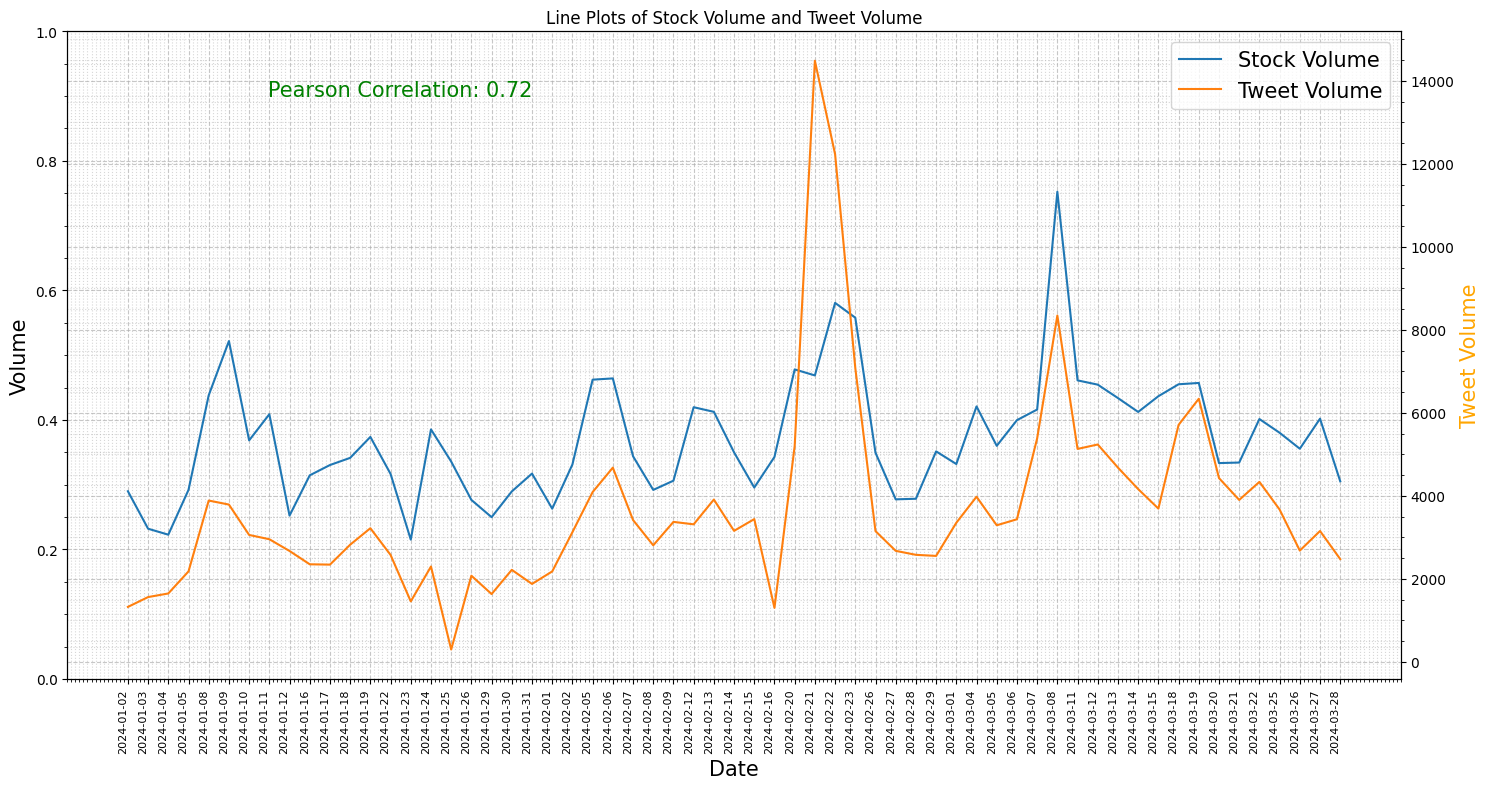

In [15]:
fig, ax = plt.subplots(figsize = (15,8))
ax2 = ax.twinx()

# Volume was divided by 10000 to make the ranges of the attributes similar
sns.lineplot(data=final_df, x='Date', y=final_df['Volume']/10000, label='Stock Volume')
sns.lineplot(data=final_df, x='Date', y=final_df['twt_volume'], label='Tweet Volume')


# Add labels and title
plt.xlabel('Date')
ax.set_ylabel("Volume", fontsize=15)
ax2.set_ylabel("Tweet Volume", fontsize=15, color= "orange")
plt.title('Line Plots of Stock Volume and Tweet Volume')

# X-lable settings
ax.set_xlabel("Date", fontsize = 15)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()
ax.grid(True,linestyle='--', alpha=0.7)
ax.grid(True, which="minor", linestyle = "dotted", alpha = 0.5)
ax.minorticks_on()
ax.tick_params(axis='x', labelsize= 8)
ax2.minorticks_on()


plt.tight_layout()
plt.legend(fontsize = 15)
plt.grid(True, linestyle = "--", alpha = 0.7)
plt.grid(True, which="minor", linestyle = "dotted", alpha = 0.5)
plt.minorticks_on()


pearson_corr = final_df['Volume'].corr(final_df['twt_volume'], method='pearson')

# Display correlation coefficients on the plot
plt.annotate(f"Pearson Correlation: {pearson_corr:.2f}", xy=(0.25, 0.9), xycoords='axes fraction', ha='center', fontsize=15, color='green')
# Show the plot
plt.show()


The number of tweets about NVIDIA on a specific day have a __very high correlation__ with the number of stock traded for NVDA

The __correlation__ between __mean sentiment__ and __stock close__

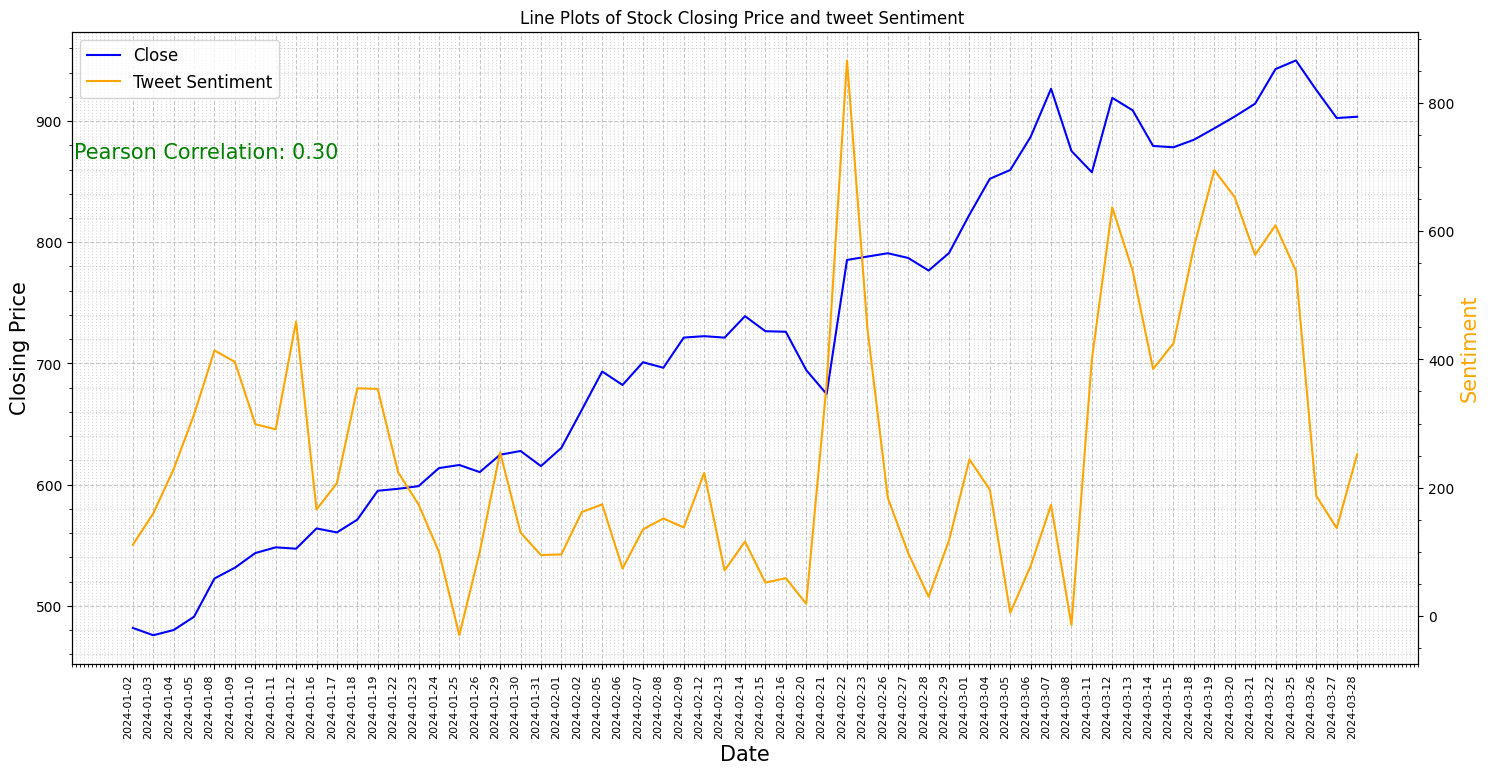

In [14]:
fig, ax = plt.subplots(figsize = (15,8))
ax2 = ax.twinx()

sns.lineplot(data=final_df, x='Date', y=final_df['Close'], label='Close', ax=ax, color = "blue")
sns.lineplot(data=final_df, x='Date', y=final_df['sen_sum'], label='Tweet Sentiment',ax=ax2, color = "orange",legend=False)

# Add labels and title
ax.set_ylabel("Closing Price", fontsize=15)
ax2.set_ylabel("Sentiment", fontsize=15, color= "orange")
plt.title('Line Plots of Stock Closing Price and tweet Sentiment ')

ax.set_xlabel("Date", fontsize = 15)
fig.autofmt_xdate(rotation=90)
plt.tight_layout()
ax.grid(True,linestyle='--', alpha=0.7)
ax.grid(True, which="minor", linestyle = "dotted", alpha = 0.5)
ax.minorticks_on()
ax.tick_params(axis='x', labelsize= 8)
ax2.minorticks_on()


lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize = 12)
pearson_corr = final_df['Close'].corr(final_df['sen_sum'], method='pearson')

# Display correlation coefficients on the plot
plt.annotate(f"Pearson Correlation: {pearson_corr:.2f}", xy=(0.1, 0.80), xycoords='axes fraction', ha='center', fontsize=15, color='green')
# Show the plot
plt.show()

The correlation between twitter sentiment and the closing price of the stock is very low. This suggests that the twitter sentiment will not significantly improve the performance of the predictive model.

#### Applying LSTM


The deep learning model that has been used in this project for stock prediction is __LSTM (Long Short-Term Memory)__.<br>
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture that is designed to overcome the limitations of traditional RNNs in capturing long-range dependencies and handling vanishing or exploding gradients. LSTMs are widely used in various sequence modeling tasks, including time series analysis, and financial forecasting, such as stock analysis.<br>

The advantages that LSTM provides for stock prediction are as follows:
- LSTMs are equipped with memory cells that allow them to remember information over long sequences. This is crucial for analyzing time series data like stock prices, where past prices and trends can have a significant impact on future movements.
-  LSTMs are well-suited for capturing time dependencies and learning patterns in sequential data.
-  LSTMs address the issue of vanishing gradient by using gating mechanisms (such as the forget gate, input gate, and output gate) to regulate the flow of information and gradients within the network.
- LSTMs are adaptable and can be customized based on the specific requirements of the stock analysis task. For example, the network architecture, hyperparameters, and training data can be adjusted to optimize performance and accuracy.

In [29]:
def assign_symbol(x):
    if x == 1:
        return 'pos'
    elif x == 0:
        return 'nue'
    else:
        return 'neg'

In [30]:
train_dates = pd.to_datetime(final_df['Date'])

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'sen_mean',
    'twt_volume'
        ]
#Date and volume columns are not used in training.

#New dataframe with only training data - 5 columns
df_for_training = final_df[cols].astype(float)
df_for_training.index=final_df['Date']
df_for_training

,Open,High,Low,Close,Volume,Adj Close,sen_mean,twt_volume
Date,,,,,,,,
2024-01-02,492.440002,492.950012,475.950012,481.679993,41125400.0,481.657410,0.083774,1325.0
2024-01-03,474.850006,481.839996,473.200012,475.690002,32089600.0,475.667694,0.102433,1562.0
2024-01-04,477.670013,485.000000,475.079987,479.980011,30653500.0,479.957489,0.138872,1649.0
2024-01-05,484.619995,495.470001,483.059998,490.970001,41456800.0,490.946960,0.143971,2181.0
2024-01-08,495.119995,522.750000,494.790009,522.530029,64251000.0,522.505493,0.106481,3888.0
...,...,...,...,...,...,...,...,...
2024-03-22,911.409973,947.780029,908.340027,942.890015,58521500.0,942.890015,0.140387,4338.0
2024-03-25,939.409973,967.659973,935.099976,950.020020,55213600.0,950.020020,0.146554,3671.0
2024-03-26,958.510010,963.750000,925.020020,925.609985,51364800.0,925.609985,0.069724,2682.0


In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])


array([[0.03636852, 0.01262714],
       [0.        , 0.        ],
       [0.00583056, 0.00904348],
       [0.02020012, 0.0322108 ],
       [0.04190958, 0.09874053],
       [0.10164166, 0.11743893],
       [0.12676253, 0.14294605],
       [0.15535704, 0.15289602],
       [0.147521  , 0.15053504],
       [0.15574988, 0.1857815 ],
       [0.18322781, 0.17884603],
       [0.20210472, 0.20106472],
       [0.21717737, 0.25132034],
       [0.25976922, 0.25475648],
       [0.24986562, 0.25937305],
       [0.2650415 , 0.29076171],
       [0.30734399, 0.29613718],
       [0.27860474, 0.28378416],
       [0.28422859, 0.3140135 ],
       [0.31871561, 0.32052731],
       [0.28852917, 0.29424006],
       [0.30217507, 0.32586071],
       [0.34092127, 0.39190548],
       [0.42881361, 0.45877246],
       [0.45786292, 0.43539431],
       [0.43075713, 0.47494106],
       [0.46704293, 0.46528627],
       [0.47653312, 0.51781871],
       [0.51926972, 0.52024286],
       [0.47378322, 0.51771333],
       [0.

In [32]:
df_for_training_scaled.shape


(61, 8)

In [33]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print(f'TrainX shape = {trainX.shape}')
print(f'TrainY shape = {trainY.shape}')

TrainX shape = (56, 5, 8)
TrainY shape = (56, 1, 2)


In [34]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-2], trainY, test_size=0.1, random_state=1)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((50, 5, 6), (50, 5, 8))

Stock Prediction with twitter sentiment

In [35]:
x_train = torch.from_numpy(X_train_lstm_twitter).type(torch.Tensor)
x_test = torch.from_numpy(X_test_lstm_twitter).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train_lstm_twitter).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test_lstm_twitter).type(torch.Tensor)

In [36]:
input_dim = 8
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 512

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [38]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [39]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    # print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print(f'MSE for training: {loss.item():.3f}')
training_time = time.time()-start_time
print(f"Training time: {training_time:.3f}")

MSE for training: 0.056
Training time: 2.043


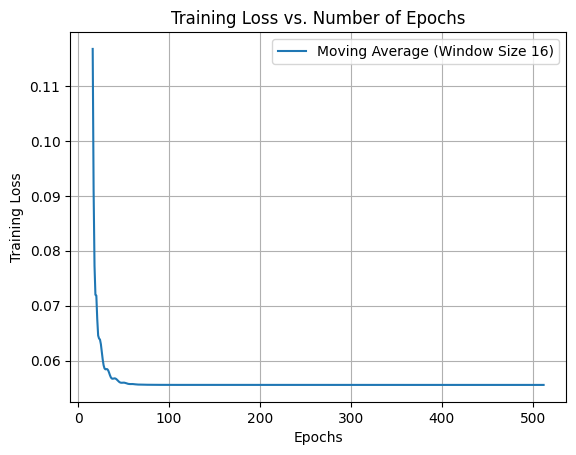

In [40]:
window_size = 16 
moving_avg = np.convolve(hist, np.ones(window_size)/window_size, mode='valid')
sns.lineplot(x = range(window_size, num_epochs + 1), y = moving_avg, label = f'Moving Average (Window Size {window_size})')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Number of Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
y_test_pred = model(x_test)
loss = criterion(y_test_pred, y_test_lstm)
print(f'MSE for testing with twitter: {loss.item():.3f}')

MSE for testing with twitter: 0.042


Stock prediction without twitter sentiment

In [42]:
x_train = torch.from_numpy(X_train_lstm_without_twitter).type(torch.Tensor)
x_test = torch.from_numpy(X_test_lstm_without_twitter).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train_lstm_without_twitter).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test_lstm_without_twitter).type(torch.Tensor)
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 512
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print(f'MSE for training: {loss.item():.3f}')
training_time = time.time()-start_time
print(f"Training time: {training_time:.3f}")
y_test_pred = model(x_test)
loss = criterion(y_test_pred, y_test_lstm)
print(f'MSE for testing without twitter: {loss.item():.3f}')


MSE for training: 0.056
Training time: 1.776
MSE for testing without twitter: 0.042


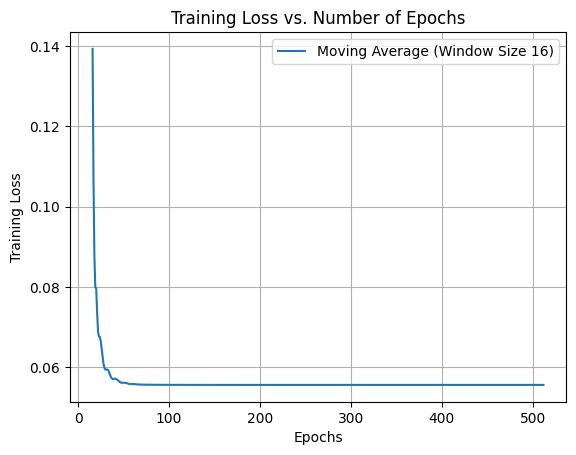

In [43]:
window_size = 16  # Adjust window size as needed
moving_avg = np.convolve(hist, np.ones(window_size)/window_size, mode='valid')
sns.lineplot(x = range(window_size, num_epochs + 1), y = moving_avg, label = f'Moving Average (Window Size {window_size})')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Number of Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusions

- The testing error for the prediction is very small (0.042). However as mentioned previously in the visualization section, given the low correlation between the twitter sentiment and the closing price, the twitter sentiment fails to meaningfully improve the predictions made by the LSTM model.<br>
- The project is limited to only the first quater of 2024 of only one company, the improvements from the sentiment maybe more noticeable for different companies or for NVIDIA over a longer period of time.<br>
- Further research, with a wider scope needs to be performed to definitively prove or disprove the viability of using twitter sentiment to predict stock movements.